In [121]:
import geojson
import pandas as pd
import shapely
from matplotlib import pyplot as plt
from matplotlib.path import Path
from pathlib import Path as pathlib
import numpy as np
from scipy.ndimage import distance_transform_edt as dt

In [122]:
sample = 'IPICRC077T1'

cell_table_filepath = f"/media/austin/IPI_8plex_project/8plex/analysis/cell_data_tables/{sample}_8plex/{sample}_8plex_single_cell_data_gated20220125.csv"

qupath_annotation_filepath = f"/media/austin/IPI_8plex_project/8plex/analysis/tumor_annotations/{sample}_8plex_annotations.txt"
 
save_filepath = f"/media/austin/IPI_8plex_project/8plex/analysis/cell_data_tables/{sample}_8plex/{sample}_8plex_single_cell_data_gated_tumorannotated_20220131.csv"

try:
    pathlib.mkdir(pathlib(save_filepath).parent)
except FileExistsError: pass

um_ppix = 0.325

tile_metadata = "/media/austin/DrosophilaMelanogaster/IPI/8plex/analysis/"+sample+"/tile_metadata.txt"

In [123]:
df = pd.read_csv(cell_table_filepath)
df = df[df['DAPI_expressed']==1]
#tile_pos_data = pd.read_csv(tile_metadata,header=None)
#tile_pos_data = tile_pos_data.rename(columns={0:"fov",1:"x1",2:"x2",3:"y1",4:"y2"})

In [124]:
y = np.array(df['centroid-0'].values, dtype=np.int16)
x = np.array(df['centroid-1'].values, dtype=np.int16)
pos = np.vstack((x,y)).transpose()

#lbl = np.array(["in_tumor_boundary"]*pos.shape[0])
in_tumor = np.array(np.zeros(pos.shape[0]), dtype=np.int8)
in_pockets = np.array(np.zeros(pos.shape[0]), dtype=np.int8)
near_border = np.array(np.zeros(pos.shape[0]), dtype=np.int8)

In [125]:
with open(qupath_annotation_filepath,"r") as f:
    data = geojson.load(f)

In [126]:
# binary image for distance transform

s = int(np.max([x.max(), y.max()]))

image = np.ones((s+10000,s+10000))
    
for i, obj in enumerate(data):

    coord_list = obj['geometry']['coordinates']
        
    coords = np.array(coord_list[0],np.uint32)
    p = Path(coords)
    tf = p.contains_points(pos)

    in_tumor[tf] = 1

    image[coords[:,0],coords[:,1]] = 0
    
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
            tf = p.contains_points(pos)
            coords = np.array(coords,np.uint32)
            image[coords[:,0],coords[:,1]] = 0
            in_tumor[tf] = 0
    
    # distance transform and then convert to microns
distance_image = dt(image)*um_ppix
distances = distance_image[x,y]
near_border[distances<10] = 1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (72,) + inhomogeneous part.

In [127]:

df['in_tumor'] = in_tumor
df['dist_tumor_boundary_um'] = distances
df['near_border'] = near_border
#df['in_pockets'] = in_pockets

try:
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('Unnamed: 0.1', axis=1)
except KeyError:
    pass
df.to_csv(save_filepath, index=None)

ValueError: Length of values (105277) does not match length of index (56932)

In [42]:
distances.sort()
print(distances)

[  0.           0.           0.         ... 593.14779408 593.16836143
 594.87270592]


<Figure size 1440x1440 with 0 Axes>

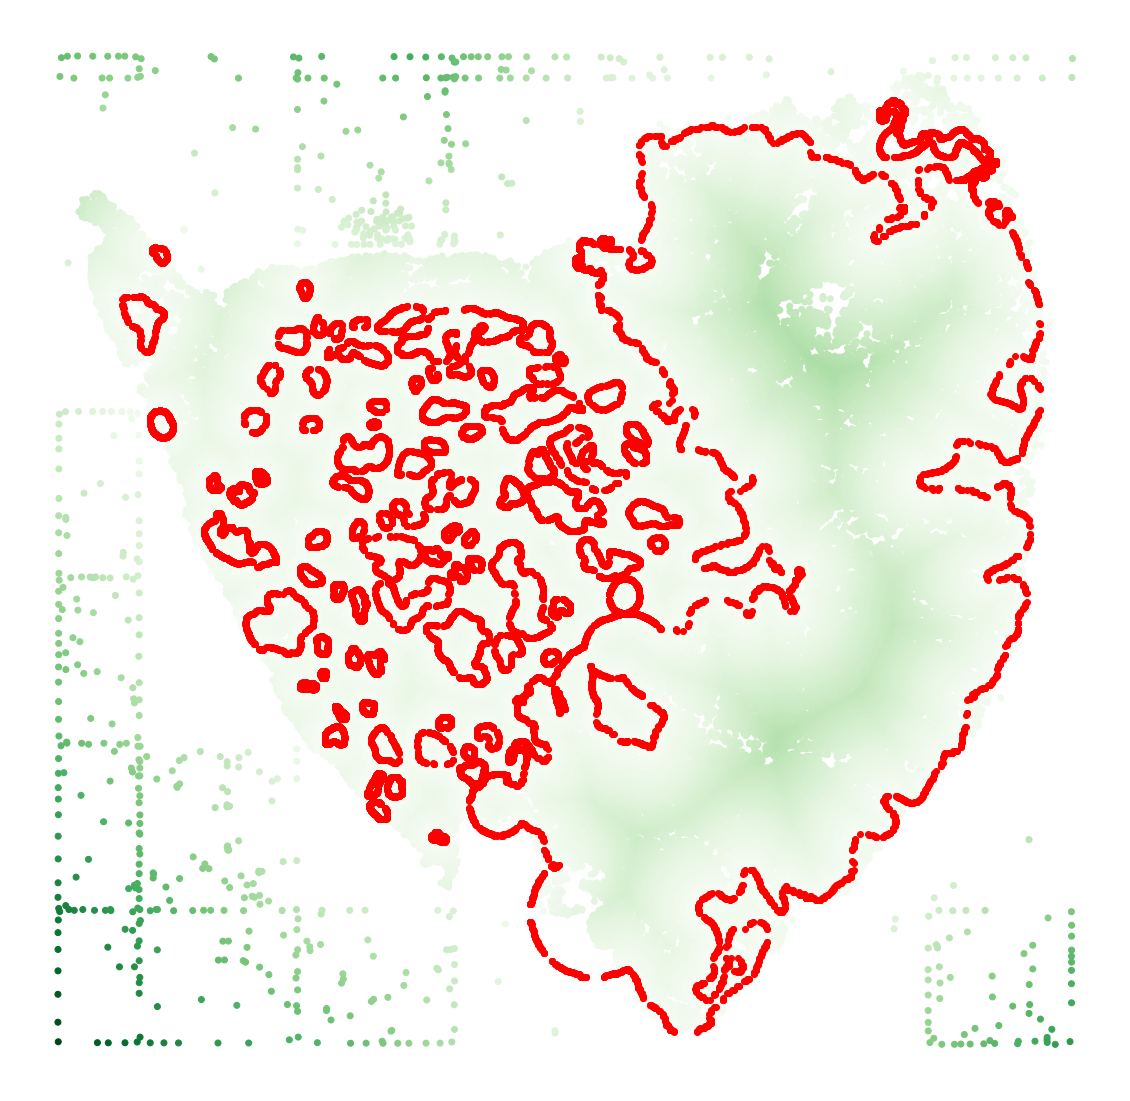

In [116]:
f = plt.figure(figsize=(20,20))

plot = True
if plot: 
    plt.figure(figsize=(20,20))
    #fig, ax = plt.subplots(1)

    
#:
    
tumor = df[df['in_tumor'] == 1] 
stroma = df[df['in_tumor'] ==0 ]
'''
plt.scatter(tumor['centroid-0'],tumor['centroid-1'],c=[1,1,0])
plt.scatter(stroma['centroid-0'],stroma['centroid-1'],c=[0,0,1])
'''

plt.scatter(y,x,c=distances,cmap='Greens')

for i, obj in enumerate(data):
    coord_list = obj['geometry']['coordinates']
        
    coords = np.array(coord_list[0])
    p = Path(coords)
    
    plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])
    
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
            plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])



plt.axis('off')
plt.show()


In [163]:
distances = distance_image[x,y]
df['in_tumor'] = lbl
df['dist_tumor_boundary_um'] = distances

df.to_csv(save_filepath, index=None)

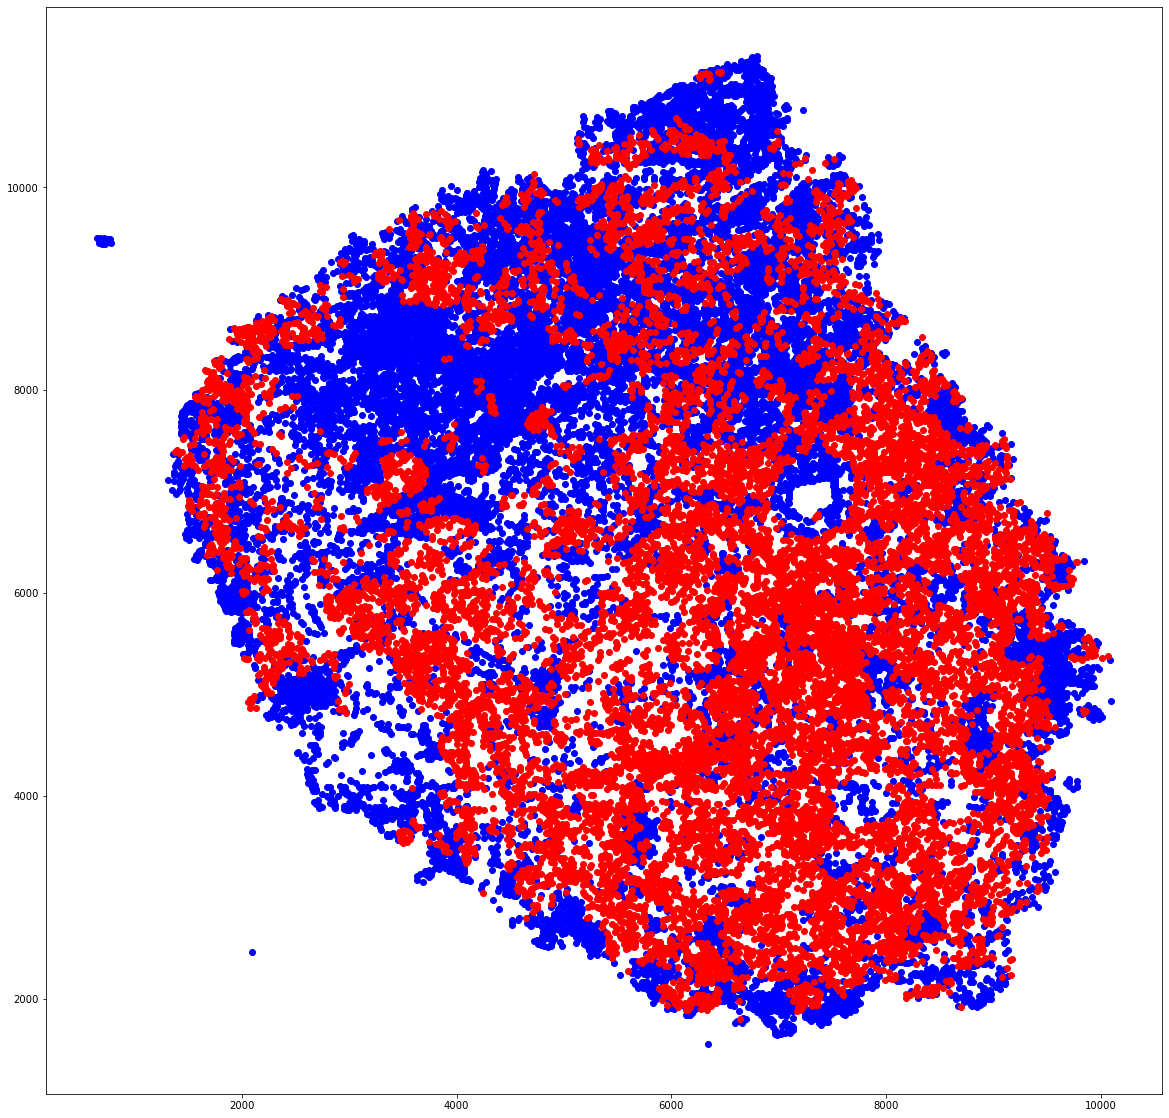